# Objective
Evaluate interpretation and evaluation of hazard ratios/hazard rates with bart vs cox

In [1]:
import sksurv as sks
import sksurv.preprocessing
import sksurv.metrics
import sksurv.datasets
import sksurv.linear_model
import sksurv.ensemble

from pathlib import Path
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import numpy as np
import sklearn as skl
import scipy.stats as sp

import pymc as pm
import pymc_bart as pmb
import pandas as pd

import importlib
import mlflow as ml
import simsurv_func as ssf
import subprocess

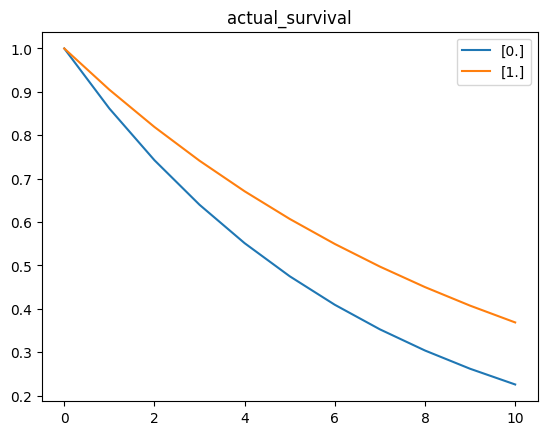

cens_calc: 0.5700000000000001     
t_mean: 2.87     
t_max: 11.0


In [4]:
OUTPUTS = "outputs"
ALPHA = 1
LAMBDA = "np.exp(2 + 0.4*x_mat[:,0])"
TRAIN_CSV = "outputs/train.csv"
RBART_CSV = "outputs/rbart_surv.csv"
N = 100
# T = 30
X_VARS = 1
CENS_SCALE = 5 # 40
CENS_IND = True

sv_mat, x_mat, lmbda, a, tlat, cens, t_event, status, T = ssf.sim_surv(
                N=N, 
                # T=T,
                x_vars=X_VARS,
                a = ALPHA,
                lambda_f = LAMBDA,
                cens_scale=CENS_SCALE,
                cens_ind = True,
                err_ind = False)


x_out, x_idx, x_cnt = ssf.get_x_info(x_mat)
event_calc, cens_calc = ssf.get_status_perc(status)
t_mean, t_max = ssf.get_event_time_metric(t_event)
train = ssf.get_train_matrix(x_mat, t_event, status)
title = "actual_survival"
ssf.plot_sv(x_mat, sv_mat, T, title=title, save = False, show=True, dir=OUTPUTS)

print(f"cens_calc: {cens_calc} \
    \nt_mean: {t_mean} \
    \nt_max: {t_max}")

In [60]:
# exp model

t = np.arange(1,25,1)

x = np.array([0])
a = 1
B = 1.2
lmbda = np.exp(0.1+ x[0] * B)
lmbda = .2


# hz = np.power(lmbda,a) * a * np.power(t, a-1) 
# hz
ht = np.outer(lmbda, a * np.power(np.outer(lmbda, t), a-1))

st = np.exp(np.power(-1 * lmbda * t, a))
ft = ht * st
ft

array([[0.16374615, 0.13406401, 0.10976233, 0.08986579, 0.07357589,
        0.06023884, 0.04931939, 0.0403793 , 0.03305978, 0.02706706,
        0.02216063, 0.01814359, 0.01485472, 0.01216201, 0.00995741,
        0.00815244, 0.00667465, 0.00546474, 0.00447415, 0.00366313,
        0.00299912, 0.00245547, 0.00201037, 0.00164595]])

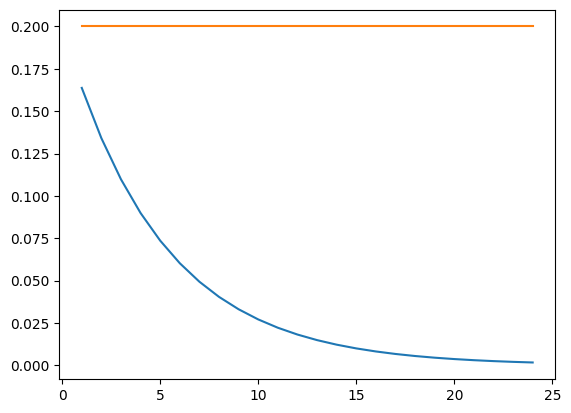

In [67]:
plt.plot(t, ft[0])
plt.plot(t, ht[0])
# t.shape
# ft.shape

In [69]:
# pm.__version__
pmb.__version__

'0.5.1'